In [1]:
# importing libraries
import numpy as np
import pandas as pd

In [2]:
# Importing the dataset
dataset = pd.read_csv('full_8classes_f_stemmer.csv')
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, 3].values

In [3]:
len(X)

354382

In [4]:
len(X)

import matplotlib.pyplot as plt

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe verdadeira')
    plt.xlabel('Classe prevista')

In [5]:
# fix empty values
for i in range(len(X[:, 0])):
    if type(X[i, 0]) is not str:
        X[i, 0] = ''
for i in range(len(X[:, 1])):
    if type(X[i, 1]) is not str:
        X[i, 1] = ''

In [6]:
# Stratified 10-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

accuracies = []
precisions = [[], [], [], [], [], [], [], []]

In [7]:
# split strafified kfold
skf = StratifiedKFold(n_splits=10, shuffle=True)
splits = skf.split(X, y)

X_train size: 318942
X_test size: 35440
Confusion matrix, without normalization
[[5671  993 1332   23   88  199  244   75]
 [2800 3010  918   53  111  369  311  121]
 [1332  292 4908   14   24   43   56    9]
 [ 272  138  183  130    7   27   15    7]
 [ 822  400  158    6  262   91   87   24]
 [1061  714  256   18   72  904  134   86]
 [ 994  491  353   17   39   97 1028  302]
 [ 712  356  235   17   44  118  508 1259]]


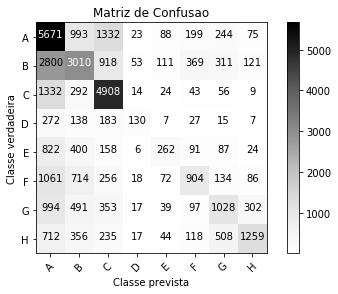

Acuracia: 0.48453724605
Acuracia A: 0.657507246377
Acuracia B: 0.391264786169
Acuracia C: 0.734950584007
Acuracia D: 0.166880616175
Acuracia E: 0.141621621622
Acuracia F: 0.278582434515
Acuracia G: 0.309545317675
Acuracia H: 0.387503847338




In [9]:
for train_index, test_index in splits:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print('X_train size: ' + str(len(X_train)))
    print('X_test size: ' + str(len(X_test)))
    
    # Vectorize titles and summary separately
    
    title_cv = CountVectorizer(max_features = None, ngram_range=(1,1))
    X_title = title_cv.fit_transform(X_train[:, 0])
    summary_cv = CountVectorizer(max_features = None, ngram_range=(1,1))
    X_summary = summary_cv.fit_transform(X_train[:, 1])
    
    # Apply SVD transformation n_components=20 and 100 separately
    svd_title = TruncatedSVD(n_components=100)
    X_title = svd_title.fit_transform(X_title)
    svd_summary = TruncatedSVD(n_components=400)
    X_summary = svd_summary.fit_transform(X_summary)
    
    # Concatenate title and summary svd representation
    X_train = np.concatenate((X_title, X_summary), axis=1)
    
    # train the model
    classifier = KNeighborsClassifier(n_jobs=-1) #RandomForestClassifier(n_estimators = 100, criterion = 'entropy', n_jobs=-1, verbose=2)
    classifier.fit(X_train, y_train)
    
    # Vectorize titles and summary separately
    X_title = title_cv.transform(X_test[:, 0])
    X_summary = summary_cv.transform(X_test[:, 1])
    
    # Apply SVD transformation n_components=20 and 100 separately
    X_title = svd_title.transform(X_title)
    X_summary = svd_summary.transform(X_summary)
    
    # Concatenate title and summary svd representation
    X_test = np.concatenate((X_title, X_summary), axis=1)
    
    # predict test set
    y_pred = classifier.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['A','B','C','D','E','F','G','H']
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusao')
    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print('Acuracia: ' + str(acc))
    
    ps = [[], [], [], [], [], [], [], []]
    for i in range(8):
        #ps[i] = accuracy_score(y_test[:,i], y_pred[:,i])
        ps[i] = cm[i, i] / np.array(cm[i, :]).sum()
        precisions.append(ps[i])
        print('Acuracia '+chr(i + 65)+': ' + str(ps[i]))
        
    print('\n')
    break